# Machine Learning Pipeline for cycle life prediction

last edit: 28.03.2022

This Notebook reads in data from processed files, generates model features, and makes pipelines for different machine learning models for predicting cycle life. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import os, random

from scipy.stats import skew, kurtosis, iqr

plt.style.use('seaborn')

In [2]:
summary = []
c10 = []
c100 = []
Qd100_10 = []

dir_summary = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\MIT\interim\summary"
dir_c10 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\MIT\interim\cycles_interpolated\cycle10_discharge"
dir_c100 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\MIT\interim\cycles_interpolated\cycle100_discharge"
dir_Qd100_10 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\MIT\interim\cycles_interpolated\DeltaQ100_10_discharge"

for file in range(len(os.listdir(dir_summary))):
    f1 = os.path.join(dir_summary, os.listdir(dir_summary)[file])
    summary.append(pd.read_csv(f1))
    
    f2 = os.path.join(dir_c10, os.listdir(dir_c10)[file])
    c10.append(pd.read_csv(f2))
    
    f3 = os.path.join(dir_c100, os.listdir(dir_c100)[file])
    c100.append(pd.read_csv(f3))
    
    f4 = os.path.join(dir_Qd100_10, os.listdir(dir_Qd100_10)[file])
    Qd100_10.append(pd.read_csv(f4))
    
print(len(summary), len(c10), len(c100), len(Qd100_10))

137 137 137 137


In [3]:
# Remove outlier cell that starts at low capacity
# error message on last index because one element is removed
for i in range(len(summary)):
    if(summary[i].iloc[1]['discharge_capacity'] < 1):
        summary.pop(i)
        Qd100_10.pop(i)
        
print(len(summary), len(Qd100_10))

IndexError: list index out of range

In [4]:
print(len(summary), len(Qd100_10))

136 136


In [5]:
c10[0]

,cycle_index,discharge_capacity,charge_capacity,voltage,current,internal_resistance,temperature,step_type,cycle_life
0,9,0.965217,1.049103,2.800000,-4.400120,0.017379,33.304352,discharge,490
1,9,0.964985,1.049103,2.800701,-4.400118,0.017379,33.308456,discharge,490
2,9,0.964753,1.049103,2.801401,-4.400116,0.017379,33.312565,discharge,490
3,9,0.964521,1.049103,2.802102,-4.400114,0.017379,33.316669,discharge,490
4,9,0.964289,1.049103,2.802803,-4.400112,0.017379,33.320774,discharge,490
...,...,...,...,...,...,...,...,...,...
995,9,0.000070,1.049103,3.497197,-4.064545,0.017379,30.490345,discharge,490
996,9,0.000070,1.049103,3.497898,-4.040684,0.017379,30.490345,discharge,490
997,9,0.000070,1.049103,3.498599,-4.016822,0.017379,30.490345,discharge,490
998,9,0.000070,1.049103,3.499299,-3.993086,0.017379,30.490345,discharge,490


# Feature Generation

The features can be split into three categories:

Features based on $\Delta Q_{100-10}(V)$
- f1: min$(\Delta Q_{100-10}(V))$
- f2: mean$(\Delta Q_{100-10}(V))$
- f3: var$(\Delta Q_{100-10}(V))$
- f4: skewness$(\Delta Q_{100-10}(V))$
- f5: kurtosis$(\Delta Q_{100-10}(V))$

Features based on the discharge capacity fade curves
- f6: Slope of the linear fit to the capacity fade curve, cycles 2 to 100
- f7: Intercept of the linear fit to capacity fade curve, cycles 2 to 100
- f8: Slope of the linear fit to the capacity fade curve, cycles 91 to 100
- f9: Intercept of the linear fit to capacity fade curve, cycles 91 to 100
- f10: Discharge capacity, cycle 2
- f11: Difference between max discharge capacity and cycle 2
- f12: Discharge capacity, cycle 100

Other features
- f13: Average charge time, first 5 cycles
- f14: Maximum temperature, cycles 2 to 100
- f15: Minimum temperature, cycles 2 to 100
- f16: Integral of temperature over time, cycles 2 to 100
- f17: Internal resistance, cycle 2
- f18: Minimum internal resistance, cycles 2 to 100
- f19: Internal resistance, difference between cycle 100 and cycle 2



The features are extracted in the cell below.

In [61]:
p = 23 # number of features, p
n = len(summary) # number of samples, n

# Target vector
y = np.zeros((n)) # (samples)

# Design matrix
X = np.zeros((n,p)) # (samples x features)

# Q100-10 features f1-f5
for i in range(len(Qd100_10)): 
    
    y[i] = np.log10(summary[i].index[-1])
    
    # Discharge related features
    X[i,0] = np.log10(abs(np.amin(Qd100_10[i]['discharge_capacity'].values)))
    X[i,1] = np.log10(abs(np.mean(Qd100_10[i]['discharge_capacity'].values)))
    X[i,2] = np.log10(np.var(Qd100_10[i]['discharge_capacity'].values))
    X[i,3] = np.log10(iqr(Qd100_10[i]['discharge_capacity'].values))
    X[i,4] = np.log10(iqr(Qd100_10[i]['discharge_capacity'].values, rng=(10,90)))
    X[i,5] = np.log10(abs(skew(Qd100_10[i]['discharge_capacity'].values)))
    X[i,6] = np.log10(abs(kurtosis(Qd100_10[i]['discharge_capacity'].values)))
    
    # Capacity related features
    Qd80_100 = summary[i]['discharge_capacity'][79:100].values
    fit80_100 = np.polyfit(np.arange(79,100), Qd80_100, 1)
    slope80_100 = fit80_100[0]
    intercept80_100 = fit80_100[1]
    
    Qd2_100 = summary[i]['discharge_capacity'][1:100].values
    fit2_100 = np.polyfit(np.arange(1,100), Qd2_100, 1)
    slope2_100 = fit2_100[0]
    intercept2_100 = fit2_100[1]
    
    Qd91_100 = summary[i]['discharge_capacity'][90:100].values
    fit91_100 = np.polyfit(np.arange(90,100), Qd91_100, 1)
    slope91_100 = fit91_100[0]
    intercept91_100 = fit91_100[1]
    
    Q_maxdiff = np.amax(summary[i]['discharge_capacity'][1:100]) - summary[i]['discharge_capacity'][1]
    
    X[i,7] = slope80_100
    X[i,8] = intercept80_100
    
    X[i,9] = slope2_100
    X[i,10] = intercept2_100
    
    X[i,11] = slope91_100
    X[i,12] = intercept91_100
    
    X[i,13] = summary[i]['discharge_capacity'][1]
    X[i,14] = Q_maxdiff
    
    # Temperature related features
    Tmin_diff = summary[i]['temperature_maximum'][100] - summary[i]['temperature_maximum'][1]
    Tmax_diff = summary[i]['temperature_maximum'][100] - summary[i]['temperature_maximum'][1]
    Tmean = np.mean(summary[i]['temperature_average'][1:100])
    Tint_diff = summary[i]['time_temperature_integrated'][100] - summary[i]['time_temperature_integrated'][1]
    
    X[i,15] = Tmin_diff
    X[i,16] = Tmax_diff
    X[i,17] = Tmean
    X[i,18] = Tint_diff
    
    # IR related features
    X[i,19] = summary[i]['dc_internal_resistance'][100] - summary[i]['dc_internal_resistance'][1]
    X[i,20] = np.mean(summary[i]['dc_internal_resistance'][1:100])
    X[i,21] = np.amin(summary[i]['dc_internal_resistance'][1:100])
    
    # Charge related features
    X[i,22] = np.mean(summary[i]['charge_duration'][1:6])

In [62]:
for i in range(X.shape[1]):
    corr = np.round(np.corrcoef(X[:,i], y), decimals=2)
    print(i, corr[1][0])

0 -0.88
1 -0.83
2 -0.86
3 -0.85
4 -0.86
5 0.32
6 -0.34
7 0.5
8 -0.26
9 0.41
10 -0.14
11 0.49
12 -0.26
13 -0.02
14 0.07
15 -0.31
16 -0.31
17 0.34
18 -0.26
19 0.33
20 -0.51
21 -0.21
22 0.35


(1.02, 1.045)

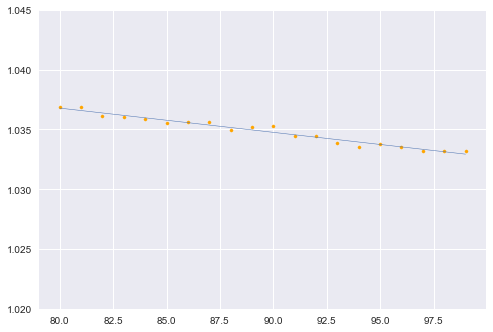

In [7]:
Qd80_100 = summary[0]['discharge_capacity'][80:100].values
cycles = np.arange(80,100)
fit80_100_lin = np.polyfit(np.arange(80,100), Qd80_100, 1)
poly1 = np.poly1d(fit80_100_lin)

plt.scatter(cycles, Qd80_100, color='orange', s=10)
plt.plot(cycles, poly1(cycles), linewidth=0.5)
plt.ylim(1.02,1.045)

### Make Elastic Net model

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_percentage_error

from functions import get_errors, get_errors2

In [10]:
def rmse_cycles(y_true, y_pred):
    return mean_squared_error(np.power(10, y_true), np.power(10, y_pred), squared=False)

#### Do gridsearch for hyperparameters

In [11]:
scorer = make_scorer(rmse_cycles, greater_is_better=False)
cv = 5

pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(max_iter=10000, tol=0.01))])
params = {'l1_ratio': [0.1,0.3,0.5,0.7,0.9,0.95,0.99,1], 'alpha': [0.00001,0.0001,0.001, 0.01, 0.1, 0.5, 1.0, 10]}
gs_en = GridSearchCV(pipe_EN[1], params, cv=cv, scoring=scorer)
gs_en.fit(X, y)
print("Best parameters for EN (CV score=%0.3f):" % gs_en.best_score_)
print(gs_en.best_params_)
print("")

Best parameters for EN (CV score=-186.306):
{'alpha': 0.0001, 'l1_ratio': 0.5}



## DONT USE THIS, USE THE ONE BELOW

In [12]:
# k-fold cross-validation
k = 10
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Make pipeline
pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(l1_ratio=0.5, alpha=0.0001, max_iter=10000, tol=0.001))])

# Full model
errors = np.zeros((k, 8)) # (# k-folds, # error metrics)
i = 0
for train_ind, test_ind in(kfold.split(X, y)):
    X_train, X_test = X[train_ind], X[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]
    
    pipe_EN.fit(X_train, y_train)
    prediction_train = pipe_EN.predict(X_train)
    prediction_test = pipe_EN.predict(X_test)
    
    errors[i,:] = get_errors(y_train, y_test, prediction_train, prediction_test)
    errors_table = pd.DataFrame({'MAE': [errors[i,0], errors[i,1]], 'RMSE CYCLES': [errors[i,2],errors[i,3]],\
                       'R2 SCORE': [errors[i,4],errors[i,5]] ,'MAPE': [errors[i,6],errors[i,7]]}, index=['train', 'test'])
    
    print("k = ", i)
    display(errors_table)
    
    i+=1
    
    #print(pipe_EN[1].coef_)
    #print("")

k =  0


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,72.008751,119.005296,0.922933,0.012424
test,154.716420,289.654377,0.745597,0.017183


k =  1


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,80.716131,138.41445,0.913195,0.012998
test,71.632119,98.37455,0.891105,0.012965


k =  2


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,75.652972,127.299790,0.924772,0.012325
test,117.143093,184.346822,0.739976,0.019900


k =  3


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,72.782685,116.686898,0.925514,0.012382
test,137.483342,216.885262,0.750861,0.023127


k =  4


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,72.259494,124.658778,0.924779,0.011894
test,144.035516,253.256691,0.597490,0.019201


k =  5


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,72.316677,117.782239,0.930858,0.011718
test,175.351956,345.533756,-100.747272,0.171578


k =  6


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,78.159776,135.595490,0.910452,0.012367
test,76.575350,114.370974,0.877166,0.017580


k =  7


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,73.009585,120.081859,0.898937,0.012552
test,181.778625,329.929494,0.888849,0.023476


k =  8


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,80.796234,135.832967,0.913370,0.013296
test,44.486308,55.244714,0.933662,0.007211


k =  9


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,73.438040,121.979285,0.929222,0.012159
test,87.884439,163.846900,0.407068,0.019523


In [13]:
print("\n\n")
print('Elastic Net model - Mean errors after cross-validation')
errors = np.mean(errors, axis=0)
errors_table = pd.DataFrame({'MAE': [errors[0], errors[1]], 'RMSE CYCLES': [errors[2],errors[3]],\
                       'R2 SCORE': [errors[4],errors[5]] ,'MAPE': [errors[6],errors[7]]}, index=['train', 'test'])
display(errors_table)




Elastic Net model - Mean errors after cross-validation


,MAE,RMSE CYCLES,R2 SCORE,MAPE
train,75.114035,125.733705,0.919403,0.012412
test,119.108717,205.144354,-9.391550,0.033174


RMSE:  138 103
R2:  0.91 0.9
MAPE:  9.0 9.5


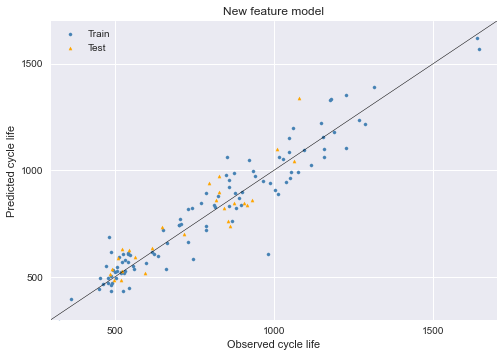

In [112]:
# Split into train/test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# Create model and fit 
pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(l1_ratio=0.5, alpha=0.0001, max_iter=10000, tol=0.001))])
pipe_EN.fit(X_train, y_train)

# Make predictions
ypred_train = pipe_EN.predict(X_train)
ypred_test = pipe_EN.predict(X_test)

# Get errors
rmse_train = round(rmse_cycles(y_train, ypred_train))
rmse_test = round(rmse_cycles(y_test, ypred_test))

r2_train = np.round(r2_score(y_train, ypred_train), decimals=2)
r2_test = np.round(r2_score(y_test, ypred_test), decimals=2)

mape_train = np.round(100*mean_absolute_percentage_error(np.power(10,y_train), np.power(10,ypred_train)), decimals=1)
mape_test = np.round(100*mean_absolute_percentage_error(np.power(10,y_test), np.power(10,ypred_test)), decimals=1)

# Print errors
print('RMSE: ', rmse_train, rmse_test)
print('R2: ', r2_train, r2_test)
print('MAPE: ', mape_train, mape_test)

x_line = np.linspace(0,1700)
y_line = np.linspace(0,1700)

plt.scatter(np.power(10,y_train), np.power(10,ypred_train), color='steelblue', s=10, label='Train')
plt.scatter(np.power(10,y_test), np.power(10,ypred_test), color='orange', marker='^', s=10, label='Test')
plt.plot(x_line,y_line, color='black', linewidth=0.5)
plt.xlim(300,1700)
plt.ylim(300,1700)
plt.xticks([500,1000,1500])
plt.yticks([500,1000,1500])
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.legend(loc='upper left')
plt.title('New feature model')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\MIT\MITpredictions\new_model.png")
plt.show()

In [113]:
print(pipe_EN[1].coef_)

[-0.04473307 -0.01789968  0.18684466 -0.18952903 -0.06510868  0.01671967
  0.05621391  0.         -0.03552524  0.01502131 -0.39642415  0.
  0.03945873  0.41049406  0.02930625 -0.01005146 -0.00106221  0.00442219
 -0.00057314 -0.01523003 -0.01187464  0.01132322  0.03074467]


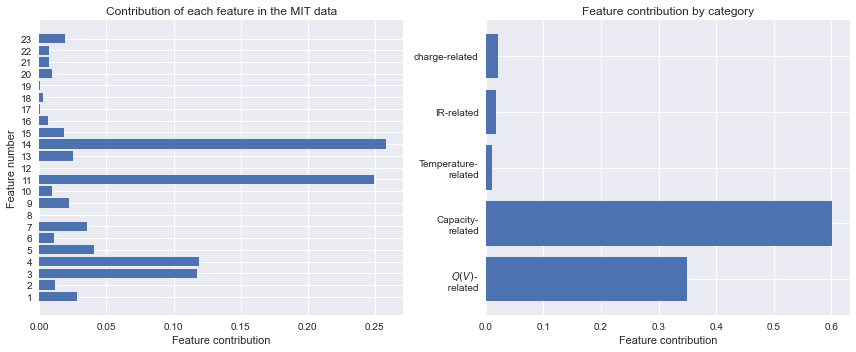

In [114]:
# Each feature
ypos1 = np.arange(1,24)
f = abs(pipe_EN[1].coef_)
fnorm = f/sum(f)

# Feature categories
Q100_10 = sum(fnorm[0:6])
cap = sum(fnorm[7:14])
temp = sum(fnorm[15:18])
IR = sum(fnorm[19:21])
charge = fnorm[22]

importance = [Q100_10, cap, temp, IR, charge]
imp_norm = importance/sum(importance)
ypos2 = np.arange(5)


names = ['$Q(V)$-\n related', 'Capacity-\nrelated', 'Temperature-\nrelated', 'IR-related', 'charge-related']


fig,ax = plt.subplots(ncols=2, figsize=(12,5))


ax[0].barh(ypos1, fnorm)
ax[0].set_yticks(np.arange(1,24))
ax[0].set_xlabel('Feature contribution')
ax[0].set_ylabel('Feature number')
ax[0].set_title('Contribution of each feature in the MIT data')

ax[1].barh(ypos2, imp_norm)
ax[1].set_yticks(ypos2)
ax[1].set_yticklabels(names)
ax[1].set_xlabel('Feature contribution')
ax[1].set_title('Feature contribution by category')
plt.tight_layout()
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\MIT\MITpredictions\new_model_fcontr.png")
plt.show()

ValueError: x and y must be the same size

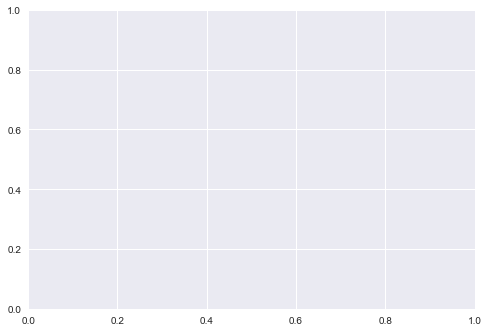

In [16]:
x_line = np.linspace(0,1700)
y_line = np.linspace(0,1700)

plt.scatter(np.power(10,y_train), np.power(10,prediction_train), color='steelblue', s=10, label='train')
plt.scatter(np.power(10,y_test), np.power(10,prediction_test), color='orange', marker='^', s=10, label='test')
plt.plot(x_line,y_line, color='black', linewidth=0.5)
plt.xlim(300,1700)
plt.ylim(300,1700)
plt.xticks([500,1000,1500])
plt.yticks([500,1000,1500])
plt.xlabel('observed cycle life') 
plt.ylabel('predicted cycle life')
plt.legend()
plt.title('EN model new')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\MIT\MITpredictions\new_model.png")